In [79]:
%matplotlib inline

import os
import time
import pickle
from multiprocessing import Pool as ThreadPool

import numpy as np
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tqdm import tqdm
from IPython.display import Math

np.random.seed(42)

In [2]:
# define some constants.

Tc = 2.0/np.log(1.+2**0.5)

# can flip this to -1 to get an anti-ferromagnetic hamiltonian
J = 1.


In [3]:
class Lattice(object):
    """
    Convenience class so you can do stuff like
    >>> lat = Lattice(N=10,T=5.0)
    >>> print lat.lattice
    >>> print lat.get_energy()
    >>> for _ in range(100): lat.step()
    >>> print lat.lattice
    >>> print lat.get_energy()
    easily.
    """

    def __init__(self, N=10, T=1.0):
        self.N = N
        self.T = T
        self.lattice = None
        self.neighbor_filter = np.array([
            [0,1,0],
            [1,0,1],
            [0,1,0]
            ])

        self.initialize()

    def initialize(self):
        """
        Initialize lattice points to -1 or 1 randomly
        """
        self.lattice = 2*np.random.randint(2, size=(self.N,self.N))-1

    def step(self):
        """
        Every iteration, select N^2 random points to try a flip attempt.
        A flip attempt consists of checking the change in energy due to a flip.
        If it is negative or less than exp(-E/(k_b*T)), then perform the flip.
        """
        for istep in range(self.N**2):
            ix = np.random.randint(0,self.N)
            iy = np.random.randint(0,self.N)
            s = self.lattice[ix,iy]
            neighbor_sum = self.lattice[(ix+1)%self.N,iy] + \
                           self.lattice[(ix-1)%self.N,iy] + \
                           self.lattice[ix,(iy+1)%self.N] + \
                           self.lattice[ix,(iy-1)%self.N]
            dE = J*2*s*neighbor_sum
            if dE < 0 or np.random.rand() < np.exp(-1.0*dE/self.T):
                s *= -1
            self.lattice[ix,iy] = s

    def get_neighbor_sum_matrix(self):
        """
        While not as efficient as computing the energy once at the beginning
        and adding the dE every step(), this is quite *fast* and elegant.
        Use a 3x3 filter for adjacent neighbors and convolve this across
        the lattice. "wrap" boundary option will handle the periodic BCs.
        This returns a NxN matrix of the sum of neighbor spins for each point.
        """
        return convolve2d(self.lattice,self.neighbor_filter,mode="same",boundary="wrap")

    def get_energy(self):
        """
        We can write the hamiltonian using optimized operations now
        """
        return -J*(self.lattice*self.get_neighbor_sum_matrix()).sum()
    
    def get_avg_magnetization(self):
        return 1.0 * self.lattice.sum() / self.N**2

    def __repr__(self):
        return str(self.lattice)

In [18]:
# Example
latLOW = Lattice(10,T=0.1)
for _ in range(30): latLOW.step()
print "Ordered phase, T=0.1"
print latLOW.lattice # (or even `print lat` to use the convenient repr)

print 

latHI = Lattice(10,T=5.0)
for _ in range(30): latHI.step()
print "Disordered phase T=5.0"
print latHI.lattice # (or even `print lat` to use the convenient repr)

Ordered phase, T=0.5
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]

Disordered phase T=5.0
[[-1 -1 -1  1  1  1  1  1 -1 -1]
 [-1  1 -1  1  1  1  1  1  1  1]
 [-1 -1 -1 -1 -1  1  1  1  1 -1]
 [ 1 -1 -1 -1 -1  1  1 -1  1  1]
 [ 1 -1 -1 -1 -1  1  1 -1  1 -1]
 [ 1 -1  1 -1 -1 -1  1  1  1  1]
 [-1 -1 -1  1  1  1  1  1  1  1]
 [ 1 -1  1  1  1  1  1  1 -1  1]
 [ 1 -1  1  1  1  1  1  1  1 -1]
 [-1  1 -1  1 -1 -1  1  1 -1 -1]]


6it [00:06,  1.00s/it]


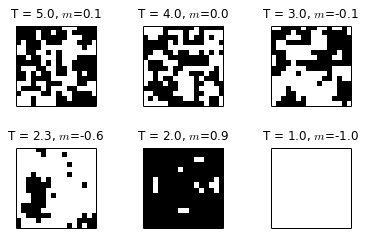

In [10]:
# Plot the spin configurations for varying temperatures.
# Display the magnetization too
nrows, ncols = 2,3
fig, axs = plt.subplots(nrows,ncols)
fig.subplots_adjust(wspace=0.6)
for ip,T in tqdm(enumerate([5.0,4.0,3.0,2.3,2.0,1.0])):
    lat = Lattice(N=16,T=T)
    for _ in range(500): lat.step()
    idx = ip // ncols, ip % ncols
    axs[idx].matshow(lat.lattice,cmap=plt.cm.gray_r)
    axs[idx].set_title("T = {:.1f}, $m$={:.1f}".format(T,lat.get_avg_magnetization()))
    axs[idx].get_xaxis().set_visible(False)
    axs[idx].get_yaxis().set_visible(False)

In [11]:
# For a temperature range, thermalize a lattice, then
# take a few hundred steps, recording energy and magnetization
# store the means to plot next.
# This takes about 60s with one modern core.
points = []
for T in np.arange(4.0,1.0,-0.05):
    lat = Lattice(N=10,T=T)
    for _ in range(500): lat.step()
    Es = []
    Ms = []
    for _ in range(200): 
        lat.step()
        Es.append(lat.get_energy())
        Ms.append(lat.get_avg_magnetization())
    Es = np.array(Es)
    Ms = np.array(Ms)
    points.append((T,Es.mean(),np.abs(Ms.mean())))
points = np.array(points)

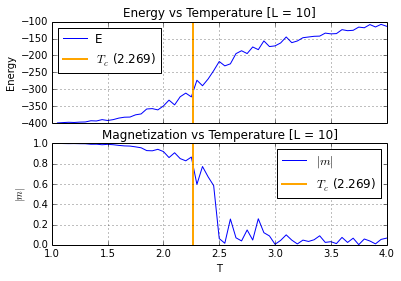

In [7]:
# Plot the energy and magnetization vs temperature

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(points[:,0],points[:,1], label="E")
axs[0].axvline(x=Tc,linestyle='-', color="orange",linewidth=2.0, label="$T_c$ ({:.3f})".format(Tc))
axs[0].set_ylabel("Energy")
axs[0].set_title("Energy vs Temperature [L = 10]")
axs[0].legend(loc="best", numpoints=1)
axs[0].grid(True)

axs[1].plot(points[:,0],points[:,2], label="$|m|$")
axs[1].axvline(x=Tc,linestyle='-', color="orange",linewidth=2.0, label="$T_c$ ({:.3f})".format(Tc))
axs[1].set_xlabel("T")
axs[1].set_ylabel("$|m|$")
axs[1].set_title("Magnetization vs Temperature [L = 10]")
axs[1].legend(loc="best", numpoints=1)
axs[1].grid(True)

In [20]:
# Use 6 threads to run some lattice evolutions
# With current parameters, this took a minute or two on an i7
# Dump out the lattice configurations/temperatures to a file
# and just load it if the file already exists, since this
# is a CPU intensive cell.

fname = "ising_config_data.pkl"

def get_lattices(T,N=10,Nlattices=25,Nthermal=200):
    lattices = []
    for _ in range(Nlattices):
        lat = Lattice(N=N,T=T)
        for _ in range(Nthermal):
            lat.step()
        lattices.append(lat.lattice)
    return round(T,4),lattices

if not os.path.exists(fname):
    pool = ThreadPool(6)
    Ts = np.arange(5.0,0.0,-0.05)
    d_data = {}
    for T,lattices in pool.imap_unordered(get_lattices, Ts):
        print T
        d_data[T] = lattices

    with open(fname,"w") as fhout:
        pickle.dump(d_data,fhout)
    print ">>> Dumped to {}".format(fname)
else:
    d_data = pickle.load(open(fname,"r"))
    print ">>> Loaded from {}".format(fname)

4.8
4.9
4.75
5.0
4.95
4.85
4.7
4.6
4.65
4.55
4.5
4.45
4.4
4.35
4.3
4.25
4.2
4.15
4.1
4.05
4.0
3.95
3.9
3.85
3.8
3.65
3.7
3.75
3.6
3.55
3.5
3.4
3.45
3.35
3.3
3.25
3.2
3.15
3.05
3.1
3.0
2.95
2.9
2.85
2.8
2.75
2.7
2.65
2.5
2.6
2.55
2.45
2.4
2.35
2.3
2.25
2.2
2.15
2.1
2.05
2.0
1.95
1.9
1.85
1.8
1.75
1.6
1.7
1.65
1.55
1.5
1.45
1.4
1.35
1.3
1.25
1.2
1.15
1.1
1.05
1.0
0.95
0.9
0.85
0.75
0.7
0.8
0.65
0.6
0.55
0.5
0.45
0.4
0.35
0.3
0.25
0.2
0.15
0.1
0.05
>>> Dumped to ising_config_data.pkl


In [25]:
# make vector of input matrices, vector of temperatures
X_data = []
y_data = []
T_data = []

for T,configs in d_data.items():
    for config in configs:
        # flip spins to double dataset keeping E same
        # this is also needed so ML algorithm doesn't learn
        # to prefer one magnetization sign over another
        # also make truth labels (0 is low T phase, 1 is high T phase)
        # and also mirror lattice horizontally/vertically to get free data
        target = 0
        if T > Tc:
            target = 1
            
        X_data.append(config)
        X_data.append(np.flip(config,0))
        X_data.append(np.flip(config,1))
        X_data.append(-config)
        X_data.append(-np.flip(config,0))
        X_data.append(-np.flip(config,1))
        
        for _ in range(6):
            T_data.append(T)
            y_data.append(target)


X_data = np.array(X_data)
y_data = np.array(y_data)
T_data = np.array(T_data)

# convert spin matrices from -1,1 to 0,1
X_data = 0.5*(X_data+1)

# Thus, our training and test sets will consist of 
# the lattice images and the targets will be 0 or 1.
# If the lattice is at low (T<Tc) or high (T>Tc) temperature
# It's up to the CNN to learn the concept of temperature/magnetization/etc.

In [78]:
# split the data
# train only on very high or very low temperature configurations, away from Tc.
# The CNN therefore tries to learn the critical temperature from states
# that are deep within either phase.
X_train, X_test, y_train, y_test, T_train, T_test = \
  train_test_split(X_data, y_data, T_data, test_size=0.3, random_state=42)

cut = np.abs(T_train-Tc)>1.5
X_train = X_train[cut]   
y_train = y_train[cut] 
T_train = T_train[cut]  
print "Training samples: ", X_train.shape[0]
print "Testing samples: ", X_test.shape[0]

Training samples:  4217
Testing samples:  4500


In [30]:
# prepare for CNN input
img_rows, img_cols = 10, 10
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [37]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=6,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print 'Test loss:', score[0]
print 'Test accuracy:', score[1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               73856     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [39]:
# predict and unbinarize
pred = model.predict(X_test)
pred = pred[:,1]
y = y_test[:,1]

high = y > 0.5
low = y < 0.5

In [40]:
def get_t_and_avgpred(Ts,preds):
    # for vector of temperatures and predictions, return
    # vector of unique temperatures and their mean predictions
    # along with standard error on mean predictions
    new_Ts = []
    new_preds = []
    new_prederrs = []
    for T in np.unique(Ts):
        new_Ts.append(T)
        new_preds.append(preds[Ts == T].mean())
        new_prederrs.append(preds[Ts == T].std()/np.sqrt(len(preds[Ts == T])))
    return np.array(new_Ts), np.array(new_preds), np.array(new_prederrs)

def sigmoid(x, x0, k):
    return 1 / (1 + 1*np.exp(-k*(x-x0)))

Predicted Tc = 2.226
       Error = 1.9%


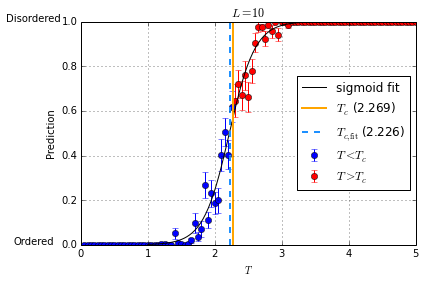

In [100]:
# Final result -- 
# Plot the average predictions for lattices in the test set
# at different temperatures. The point at which the prediction
# passes through 0.5 is the critical temperature. I.e., at a phase
# transition. So we fit a sigmoid to the points and use this to estimate the crossing point (`Tc_fit`)
Ts_low, preds_low, prederrs_low = get_t_and_avgpred(T_test[low],pred[low])
Ts_high, preds_high, prederrs_high = get_t_and_avgpred(T_test[high],pred[high])

# fit a sigmoid to the average predictions
popt, pcov = curve_fit(sigmoid, np.r_[Ts_low,Ts_high], np.r_[preds_low,preds_high])
xfit = np.linspace(1.0,5.0,200)
yfit = sigmoid(xfit, *popt)
# and figure out for what T the fit line is closest to 0.5
Tc_fit = xfit[np.argmin(np.abs(yfit-0.5))]

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.errorbar(Ts_low,preds_low, yerr=prederrs_low, fmt="bo", label="$T<T_c$")
ax.errorbar(Ts_high,preds_high, yerr=prederrs_high, fmt="ro", label="$T>T_c$")
ax.plot(xfit,yfit, "k-", label="sigmoid fit")
ax.plot([Tc,Tc],[0.,1.],'-', color="orange",linewidth=2.0, label="$T_c$ ({:.3f})".format(Tc))
ax.plot([Tc_fit,Tc_fit],[0.,1.0],'--', color="dodgerblue",linewidth=2.0, label="$T_{{c,\mathrm{{fit}}}}$ ({:.3f})".format(Tc_fit))
ax.set_xlabel("$T$")
ax.set_ylabel("Prediction")
ax.set_ylim(0,1)
ax.annotate("Disordered",xy=(0,0), xytext=(-1.1,1))
ax.annotate("Ordered",xy=(0,0), xytext=(-1,0))
ax.set_title("$L = 10$")
ax.legend(loc="center right", numpoints=1)
ax.grid(True)

print "Predicted Tc = "+str(round(Tc_fit,3))
print "       Error =", str(round(np.abs(Tc_fit-Tc)/Tc*100,2))+"%"